<a href="https://colab.research.google.com/github/elenek97/TMA4900/blob/main/Master_fra_prosjekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-task forecasting model with imputation as helping task
A bi-directional LSTM neural network for time series with missing data is trained jointly with an imputation task with the aim of improved performance utilizing information fron the related task.

In [2]:
! pip install --quiet pytorch-lightning
! pip install --quiet einops
! pip install --quiet pmdarima

     |████████████████████████████████| 819kB 8.1MB/s 
     |████████████████████████████████| 10.6MB 33.9MB/s 
     |████████████████████████████████| 235kB 38.8MB/s 
     |████████████████████████████████| 122kB 43.8MB/s 
     |████████████████████████████████| 645kB 38.1MB/s 
     |████████████████████████████████| 829kB 34.7MB/s 
     |████████████████████████████████| 1.3MB 34.7MB/s 
     |████████████████████████████████| 143kB 35.2MB/s 
     |████████████████████████████████| 296kB 39.8MB/s 
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.
     |████████████████████████████████| 1.5MB 8.5MB/s 
     |████████████████████████████████| 9.5MB 35.3MB/s 


In [3]:
%matplotlib inline
from IPython.display import clear_output
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch
import matplotlib.pyplot as plt
from google.colab import files
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import time
import tensorflow as tf
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, RobustScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from google.colab import drive
from einops import repeat
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"


Connect colab to drive:

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Check if GPU available:

In [5]:
# checking if GPU is available
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(is_cuda)

True


# Load data

## Electricity data

In [6]:
df1 = pd.read_csv("/content/gdrive/MyDrive/ElectricityData/AEP_hourly.csv")
df2 = pd.read_csv("/content/gdrive/MyDrive/ElectricityData/NI_hourly.csv")
df3 = pd.read_csv("/content/gdrive/MyDrive/ElectricityData/COMED_hourly.csv")
df4 = pd.read_csv("/content/gdrive/MyDrive/ElectricityData/DAYTON_hourly.csv")
df5 = pd.read_csv("/content/gdrive/MyDrive/ElectricityData/DEOK_hourly.csv")
df6 = pd.read_csv("/content/gdrive/MyDrive/ElectricityData/DOM_hourly.csv")
df7 = pd.read_csv("/content/gdrive/MyDrive/ElectricityData/DUQ_hourly.csv")
df8 = pd.read_csv("/content/gdrive/MyDrive/ElectricityData/EKPC_hourly.csv")
df9 = pd.read_csv("/content/gdrive/MyDrive/ElectricityData/FE_hourly.csv")
df10 = pd.read_csv("/content/gdrive/MyDrive/ElectricityData/PJME_hourly.csv")

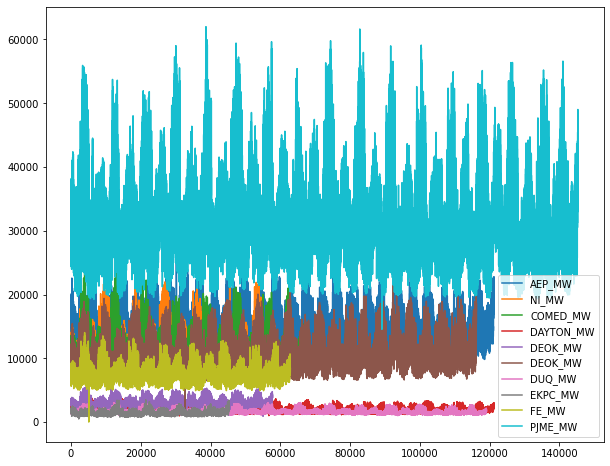

In [7]:
plt.figure(figsize=(10,8))
plt.plot(df1['AEP_MW'], label='AEP_MW')
plt.plot(df2['NI_MW'],label='NI_MW')
plt.plot(df3['COMED_MW'], label='COMED_MW')
plt.plot(df4['DAYTON_MW'], label='DAYTON_MW')
plt.plot(df5['DEOK_MW'], label='DEOK_MW')
plt.plot(df6['DOM_MW'], label = 'DEOK_MW')
plt.plot(df7['DUQ_MW'], label = 'DUQ_MW')
plt.plot(df8['EKPC_MW'], label = 'EKPC_MW')
plt.plot(df9['FE_MW'], label = 'FE_MW')
plt.plot(df10['PJME_MW'], label ='PJME_MW')
plt.legend()
plt.show()

## Synthetic SARIMA data

In [8]:
sarima = pd.read_csv("/content/gdrive/MyDrive/Master/differentsarimasimulations.csv")

In [9]:
sarima = sarima.drop('Unnamed: 0', axis=1)
columns = sarima.columns
sarimats = []
for name in columns:
  sarimats.append(sarima[name])

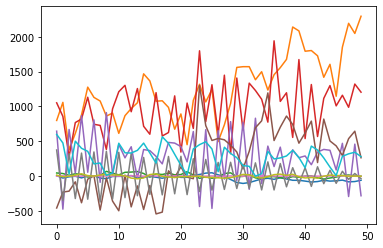

In [10]:
plt.figure()
plt.plot(sarimats[0])
plt.plot(sarimats[11])
plt.plot(sarimats[22])
plt.plot(sarimats[33])
plt.plot(sarimats[45])
plt.plot(sarimats[55])
plt.plot(sarimats[65])
plt.plot(sarimats[78])
plt.plot(sarimats[89])
plt.plot(sarimats[99])
plt.show()

# Build model

## The robust missing value indicator approach

In [11]:
def expand_missing(x, missing_rate, n_features, device=device):
  """A function that automatically simulates missing data 
  and adds a missing value indicator."""
  b, len_seq, chan = x.shape
  expand = missing_rate * torch.ones_like(x, device=device)
  mask = torch.bernoulli(expand) 
  remove = 1. - mask
  miss_x = remove * x
  out = torch.cat([miss_x, mask], -1)
  return out, x, mask

## Pytorch Lightning Data Module

In [16]:
class timeseriesDataModule(pl.LightningDataModule):
    '''
    PyTorch Lighting DataModule subclass:
    https://pytorch-lightning.readthedocs.io/en/latest/datamodules.html

    Serves the purpose of aggregating all data loading 
      and processing work in one place.
    '''
    
    def __init__(self, datalist, seq_len , batch_size ,  num_workers=1, train_fraction=0.7, val_fraction=0.15, val_test_missing_rate=0.):
        super().__init__()
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.datalist = datalist#[dt.set_index('Datetime').iloc[:, 0] for dt in datalist] #syntetisk data: datalist
        self.train_fraction = train_fraction
        self.val_fraction = val_fraction
        self.test_fraction = 1 - self.train_fraction - self.val_fraction
        self.val_test_missing_rate = val_test_missing_rate
        self.scaler = RobustScaler()
        self._setup()
        

        
    def prepare_data(self):
        pass
    
    
    ###################### MAIN SETUP FUNCTION: Returns the expanded data with missing value indicator###
    def _setup(self):
      torch.manual_seed(0)
      train, val, test = [], [], []
    
      for dt in self.datalist:
        dt = self._scale_dataframe(dt)            # scale
        tr1, vl1, te1 = self._process_one_df(dt)  # split into train, val, test
        train.extend(tr1)                         # add train part of this time series to the main train data list
        val.extend(vl1)                           # add val part of this time series to the main val data list
        test.extend(te1)                          # add test part of this time series to the main test data list

      #remove values and add missing value indicator. 
      self.test_orig = test
      self.train_data, self.complete_train = self._process_stack(train, missing_rate = self.val_test_missing_rate) 
      self.val_data, self.complete_val = self._process_stack(val, missing_rate = self.val_test_missing_rate)  
      self.test_data , self.complete_test = self._process_stack(test, missing_rate = self.val_test_missing_rate) 
    

    ####################### DIFFERENT FUNCTIONS NEEDED TO DO THE SETUP: ##################################

    def _scale_dataframe(self, dt):
      """This function scales the data"""
      dt = dt.to_frame() #kommenter denne ut for syntetisk data
      n_train, _ = self._get_n_samples_in_split(dt.shape[0])
      scaler = self.scaler.fit(dt.iloc[:n_train])
      return pd.Series(scaler.transform(dt)[:,0], index=dt.index, name='target')
    
    
    def _process_one_df(self, df): 
      """This function splits time series into train, validation and test set"""
      seqs = self._create_sequence_data(df.values)
      n_train, n_val = self._get_n_samples_in_split(len(seqs))
      train = seqs[:n_train]
      val = seqs[n_train:n_train + n_val]
      test = seqs[n_train + n_val:]
      return train, val, test
    
    def _create_sequence_data (self, input_data): 
      '''Divide the concatenated tensors into sequences of length seq_len'''
      L = len(input_data)
      inout_seq = []
      for i in range (L - self.seq_len):
          x = torch.from_numpy(input_data[i : i+self.seq_len])
          y = torch.from_numpy(input_data[i+self.seq_len : i+self.seq_len+1])
          inout_seq.append((x, y))
      return inout_seq

    def _process_stack(self, data, missing_rate = None):
      
      inp_data = torch.stack([d[0] for d in data]).unsqueeze(-1).float().to(device)
      complete_data = inp_data
      print(len(complete_data))
      targ = torch.FloatTensor([d[1] for d in data]).to(device)
      return (inp_data, targ), complete_data

    def _get_n_samples_in_split(self, n_values):
      return int(self.train_fraction * n_values), int(self.val_fraction * n_values)

    def train_dataloader(self):
        ds = TensorDataset(*self.train_data)
        return DataLoader(ds, batch_size=self.batch_size)

    def val_dataloader(self):
        ds = TensorDataset(*self.val_data)
        return DataLoader(ds, batch_size=self.batch_size)

    def test_dataloader(self):
        ds = TensorDataset(*self.test_data)
        return DataLoader(ds, batch_size=self.batch_size*10)

In [13]:
class biLSTMRegressor(pl.LightningModule):
    '''
    Standard PyTorch Lightning module:
    https://pytorch-lightning.readthedocs.io/en/latest/lightning_module.html
    '''
    def __init__(self, 
                 n_features, 
                 hidden_size, 
                 seq_len, 
                 batch_size,
                 num_layers, 
                 dropout, 
                 learning_rate,
                 criterion1,
                 criterion2,
                 max_missing_rate,
                 test_miss_rate,
                 alpha):
      
        self.missing_threshold = 1.e-2
        super(biLSTMRegressor, self).__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.criterion1 = criterion1
        self.criterion2 = criterion2
        self.learning_rate = learning_rate
        self.alpha = alpha
        self.max_missing_rate = max_missing_rate
        self.test_miss_rate = test_miss_rate
        
  
        self.lstm = nn.LSTM(input_size=n_features, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            dropout=dropout, 
                            batch_first=True, bidirectional=True)
        
        self.linear = nn.Linear(hidden_size*2, 1) #linear layer for forecasting 
        self.relu = nn.ReLU()
        self.impute_linear = nn.Linear(hidden_size*2, 1) #linear layer for sequence imputation 
         

    def imputation_loop(self, lstm_out, orig_x, miss_x, mask):
            
        seq_preds = [] 
        comp_x_vals = []

        for i in range(self.seq_len):
          hidden_layer_t = lstm_out[:,i,:] 
          mask1 = mask[:,i,:]
          imputed = self.impute_linear(hidden_layer_t)
          imputed = imputed*mask1
          imputed = imputed.unsqueeze(-1)
          seq_preds.append(imputed)  

          comp_x = orig_x[:,i,:]*mask1
          comp_x_vals.append(comp_x)
              
        seq_preds = torch.stack(seq_preds, dim = 1)
        seq_preds = seq_preds.squeeze(-1)
        comp_x_vals  = torch.stack(comp_x_vals, dim = 1)
        return seq_preds, comp_x_vals  

    def forward(self, x, miss_rate):
        #rintroduce missing data and expand the structure with a missing value indicator
        miss_x , orig_x, mask = expand_missing(x, miss_rate, self.n_features)
        

        #encoder
        lstm_out, _ = self.lstm(miss_x)

        lstm_out_copy = lstm_out.clone()

        #prediction decoder
        #yrelu = self.relu(lstm_out[:,-1])
        #y_hat = self.linear(yrelu)#
        y_hat = self.linear(lstm_out[:,-1])

        #imputation decoder
        seq_preds, comp_x_vals = self.imputation_loop(lstm_out_copy, orig_x, miss_x, mask)

        num_missing = sum(sum(mask))
        return y_hat.squeeze(), seq_preds, comp_x_vals, num_missing 
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = self.learning_rate)

    

    def training_step(self, batch, batch_idx):
        x, y = batch  
        y_hat, seq_preds, comp_x_vals, num_missing = self.forward(x,self.max_missing_rate)
        # prediction loss
        loss_pred = self.criterion1(y_hat, y)
        
        if (self.alpha==0.):
          loss = loss_pred
          self.log('train_loss', loss)
          return loss
        else:
          #imputation loss
          loss_imputation = self.criterion2(seq_preds, comp_x_vals)/num_missing
          

          #total loss
          loss = loss_pred + self.alpha*loss_imputation
          self.log('train_loss', loss)
          return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch        
        y_hat, seq_preds, comp_x_vals, num_missing = self.forward(x, self.max_missing_rate)

        #prediction loss
        loss_pred = self.criterion1(y_hat, y)
        
      
        if (self.alpha==0.):
          loss = loss_pred
          self.log('val_loss', loss)
          return loss
        else:
          #imputation loss
          loss_imputation = self.criterion2(seq_preds, comp_x_vals)/num_missing 
          #total loss
          loss = loss_pred + self.alpha*loss_imputation
          self.log('val_loss', loss)
          return loss
    
    def test_step(self, batch, batch_idx):

        x, y = batch 
      

        y_hat, seq_preds, comp_x_vals,num_missing  = self.forward(x, self.test_miss_rate)
        #prediction loss
        loss_pred = self.criterion1(y_hat, y)
        
        if (self.alpha==0.):
          loss = loss_pred
          self.log('test_loss', loss)
          return loss
        else:
          #imputation loss
          loss_imputation = self.criterion2(seq_preds, comp_x_vals)/num_missing
          #total loss
          loss = loss_pred + self.alpha*loss_imputation
          self.log('test_loss', loss)
          return loss

# Model training

In [14]:
'''
All parameters are aggregated in one place.
This is useful for reporting experiment params to experiment tracking software
'''
model_params = dict(
    seq_len = 25,
    batch_size = 64, #128, 
    criterion1 = nn.MSELoss(), #mean MSE
    criterion2 = nn.MSELoss(reduction ='sum'), #for imputation (sum and divide on the number imputed)
    n_features = 2, #time series + missing value indicator
    dropout = 0.2,
    learning_rate = 0.001, #electricity: 0.0001
    test_miss_rate = 0.,

    hidden_size = 100,
    num_layers = 2,
    max_missing_rate = 0.02, #ratio of missing values during training
    alpha = 1.2 #weigth of imputation loss
)
trainer_params = dict(max_epochs=15, gpus=1, logger=CSVLogger('./', name='lstm', version='1'), progress_bar_refresh_rate=20)


In [17]:
#datamodule = timeseriesDataModule([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10], seq_len=25, batch_size=128) 
datamodule = timeseriesDataModule(sarimats, seq_len = 25, batch_size = 64)

1700
300
500


In [18]:
seed_everything(1)

trainer = Trainer(**trainer_params,callbacks=[EarlyStopping(monitor='val_loss')])

model = biLSTMRegressor(**model_params)

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [19]:
trainer.fit(model, datamodule = datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type    | Params
------------------------------------------
0 | criterion1    | MSELoss | 0     
1 | criterion2    | MSELoss | 0     
2 | lstm          | LSTM    | 324 K 
3 | linear        | Linear  | 201   
4 | relu          | ReLU    | 0     
5 | impute_linear | Linear  | 201   
------------------------------------------
325 K     Trainable params
0         Non-trainable params
325 K     Total params
1.301     Total estimated model params size (MB)


Global seed set to 1


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  "Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2"


    val_loss  epoch
0   0.891881      0
2   0.749778      1
3   0.784107      2
5   0.928591      3
6   0.743382      4
8   0.896437      5
9   0.760882      6
11  0.973499      7


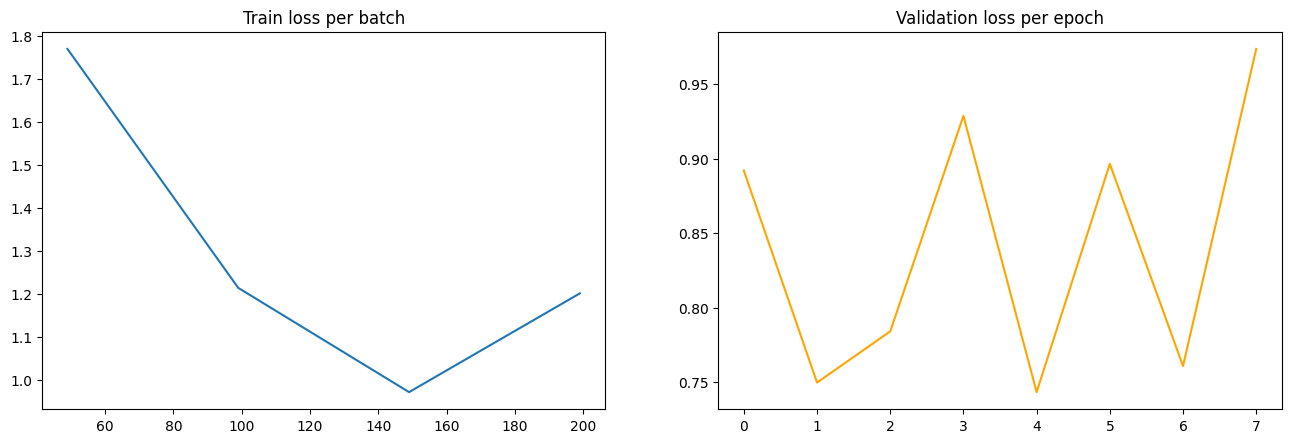

In [20]:
metrics = pd.read_csv('./lstm/1/metrics.csv')
train_loss = metrics[['train_loss', 'step', 'epoch']][~np.isnan(metrics['train_loss'])]
val_loss = metrics[['val_loss', 'epoch']][~np.isnan(metrics['val_loss'])]
print(val_loss)
fig, axes = plt.subplots(1, 2, figsize=(16, 5), dpi=100)
axes[0].set_title('Train loss per batch')
axes[0].plot(train_loss['step'], train_loss['train_loss'])
axes[1].set_title('Validation loss per epoch')
axes[1].plot(val_loss['epoch'], val_loss['val_loss'], color='orange')
plt.show(block = True)

#Test model

In [21]:
def predict_and_impute(model, dataloader, miss_rate, criterion, device = device):
    model.to(device)
    model.eval()
    prediction_list = []
    actual_value = []
    total_pred_loss = 0
    total_imputation_loss = 0
    with torch.no_grad():
      for data in (dataloader):
        input = data[0].to(device)
        label = data[1].to(device)
        yhat, seq_preds, comp_x_vals, num_imp = model(input, miss_rate)
        prediction_list.append(yhat.squeeze(-1))
        actual_value.append(label)
        loss1 = criterion(label,yhat)
        loss2 = criterion(seq_preds, comp_x_vals)/num_imp
        total_pred_loss += loss1 
        total_imputation_loss += loss2
    return prediction_list, actual_value, total_pred_loss, total_imputation_loss

In [23]:
criterion = nn.MSELoss()
batch_size=64 #128
test_loader = DataLoader(TensorDataset(datamodule.test_data[0],datamodule.test_data[1]), batch_size=batch_size*10)

In [46]:
def mse_with_missing_data(model, test_loeader, criterion):
  missing_ratios = [0,0.02,0.05,0.1,0.2,0.5]
  test_losses = []
  imp_loss = []
  yhats = []
  ys = []
  for ratio in missing_ratios:
    yhat1,y1,loss1,loss2 = predict_and_impute(model, test_loader, ratio, criterion)
    test_losses.append(loss1.cpu())
    yhats.append(yhat1)
    ys.append(y1)
    imp_loss.append(loss2)
  print('MSE losses:\n0%:', test_losses[0].numpy(),'\n2%:',test_losses[1].numpy(), '\n5%:',test_losses[2].numpy(), '\n10%:',test_losses[3].numpy(), '\n20%:',test_losses[4].numpy(), '\n50%:', test_losses[5].numpy())
  return test_losses, yhats

In [47]:
mses, yhats = mse_with_missing_data(model, test_loader, criterion)


MSE losses:
0%: 0.5113129 
2%: 0.51919496 
5%: 0.53193486 
10%: 0.5387821 
20%: 0.5899803 
50%: 0.70956576


# Calculate the backscaled losses to compare with sarima model: 

In [29]:
test_data = sarima[-5:]
test_data_noindex = test_data.reset_index()
test_data=test_data_noindex.drop(['index'], axis=1)
test_data_flattened = []
for i in range(len(columns)):
  test_data_flattened.append(test_data[columns[i]].tolist())
  #flatten to plot
test_data_flattened = sum(test_data_flattened,[])

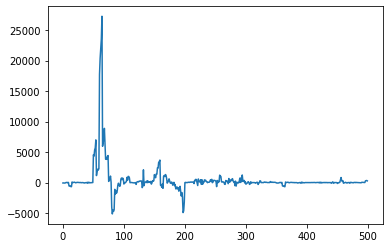

In [30]:
plt.plot(test_data_flattened)

In [80]:
yhat_backscaled = datamodule.scaler.inverse_transform(np.array(yhats[5][0].cpu()).reshape(-1,1))

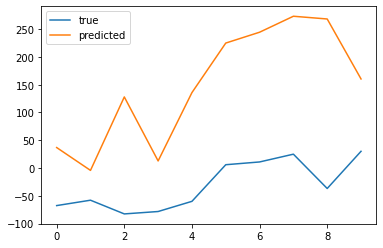

In [90]:
plt.plot(test_data_flattened[0:10], label='true')
plt.plot(yhat_backscaled[0:10], label='predicted')
plt.legend()

In [82]:
mse = sklearn.metrics.mean_squared_error(yhat_backscaled,test_data_flattened)
print(mse)

6297431.154910011


## Two hidden layers of size 100 for sarima data: 

In [40]:
missing_ratios = [0, 0.02 ,0.05, 0.1, 0.2, 0.5]
mse_alpha002 = [6150982.367957313, 6160276.07230986, 6160598.426798089, 6174782.349959003, 6192916.742011066, 6280789.30599632]
mse_alpha120 = [6147059.520201462, 6152927.692458773, 6159454.555190967, 6166726.314141403, 6190783.197176749, 6297431.154910011]

6150982.367957313
